In [1]:
import pandas as pd
from bamt.networks.hybrid_bn import HybridBN
from sklearn import preprocessing as pp
import bamt.preprocessors as preprocessor
from pgmpy.estimators import K2Score
import statsmodels.api as sm

/Users/olgashtykina/Desktop/Maths_in_ML/lab4/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = 'data/df2.csv'
data = pd.read_csv(file_path)

data = data[['yj13.2','yj72.18a','yj6.2','yj10.2','yj21b','yj1.1.1']]
data.rename(columns = {'yj13.2':'ЗП',
                     'yj72.18a':'Образование',
                     'yj6.2':'Рабочая неделя',
                     'yj10.2':'Премия',
                     'yj21b':'Отпуск',
                       'yj1.1.1': 'Удовлетворённость'
                       },
                inplace = True)

In [3]:
# Первоначальный вид данных
data.head(10)

,ЗП,Образование,Рабочая неделя,Премия,Отпуск,Удовлетворённость
0,25000.000000,2.0,40.0,11572.206741,42.0,3.0
1,18000.000000,2.0,60.0,8205.665614,21.0,4.0
2,30000.000000,1.0,48.0,4229.458428,19.0,4.0
3,38000.000000,3.0,40.0,2053.307000,28.0,1.0
4,40000.000000,3.0,40.0,4102.242173,28.0,1.0
5,8957.381937,2.0,40.0,3414.671314,29.0,3.0
6,15000.000000,1.0,40.0,974.728783,28.0,2.0
7,30000.000000,3.0,40.0,7872.907211,14.0,2.0
8,24647.223765,1.0,42.0,6015.938148,21.0,2.0
9,20000.000000,3.0,40.0,11064.417500,14.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3402 entries, 0 to 3401
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ЗП                 3402 non-null   float64
 1   Образование        3402 non-null   float64
 2   Рабочая неделя     3402 non-null   float64
 3   Премия             3402 non-null   float64
 4   Отпуск             3402 non-null   float64
 5   Удовлетворённость  3402 non-null   float64
dtypes: float64(6)
memory usage: 159.6 KB


In [5]:
# Данный шаг выполнен, чтобы фреймворк понимал какие величины дискретные, а какие непрерывные
data['Образование'] = data['Образование'].astype(str)
data['Удовлетворённость'] = data['Удовлетворённость'].astype(str)

Дискретизация данных

In [6]:
encoder = pp.LabelEncoder()
discretizer = pp.KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
p = preprocessor.Preprocessor([("encoder", encoder), ("discretizer", discretizer)])
discretized_data, est = p.apply(data)

In [7]:
discretized_data

,ЗП,Образование,Рабочая неделя,Премия,Отпуск,Удовлетворённость
0,2,1,1,4,3,2
1,1,1,2,3,1,3
2,3,0,2,2,0,3
3,4,2,1,0,2,0
4,4,2,1,2,2,0
...,...,...,...,...,...,...
3397,3,1,2,4,2,1
3398,3,0,2,2,1,2
3399,1,1,1,3,0,2
3400,4,1,1,3,2,1


In [8]:
est

{'Образование': {'1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3},
 'Удовлетворённость': {'1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4}}

In [9]:
p.info

{'types': {'ЗП': 'cont',
  'Образование': 'disc',
  'Рабочая неделя': 'cont',
  'Премия': 'cont',
  'Отпуск': 'cont',
  'Удовлетворённость': 'disc'},
 'signs': {'ЗП': 'pos',
  'Рабочая неделя': 'pos',
  'Премия': 'pos',
  'Отпуск': 'pos'}}

In [10]:
# Инициализация гибридной байесовской сети
bn = HybridBN(has_logit=False, use_mixture=True)
bn.add_nodes(p.info)

In [11]:
# Обучение структуры байесовской сети с помощью Hill Climbing
bn.add_edges(discretized_data,scoring_function=('K2',K2Score), optimizer='HC')

  0%|          | 8/1000000 [00:00<1:09:26, 240.03it/s]


In [12]:
bn.plot('Structure.html')

Структура DAG

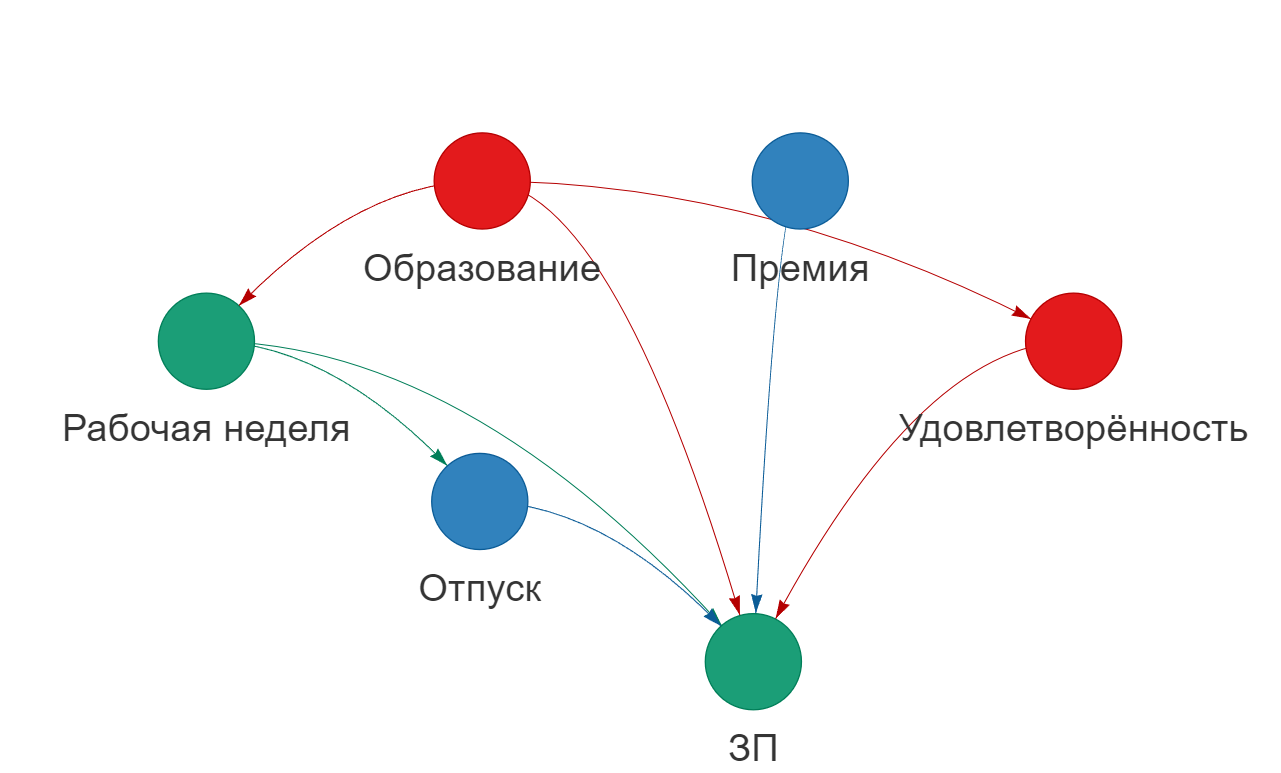

In [13]:
# Обучение параметров
bn.fit_parameters(data)

Несбалансированность датасета

In [14]:
data['Удовлетворённость'].value_counts()


Удовлетворённость
2.0    1966
3.0     742
1.0     475
4.0     193
5.0      26
Name: count, dtype: int64

Процесс семплирования недостающих классов

In [15]:
# Сабсет из недостающего класса "5.0"
five = data[data['Удовлетворённость'] == '5.0']
five

,ЗП,Образование,Рабочая неделя,Премия,Отпуск,Удовлетворённость
48,10000.000000,2.0,40.0,5095.756356,28.0,5.0
70,20000.000000,2.0,40.0,5057.388949,42.0,5.0
103,10000.000000,2.0,36.0,6687.370987,28.0,5.0
205,28000.000000,3.0,40.0,2032.243497,48.0,5.0
270,13050.000000,3.0,40.0,10644.201561,21.0,5.0
290,22000.000000,3.0,40.0,19229.639169,28.0,5.0
360,40000.000000,2.0,40.0,2047.339339,12.0,5.0
471,34765.153043,1.0,60.0,7727.599208,31.0,5.0
761,15000.000000,1.0,40.0,5296.397095,28.0,5.0
809,18000.000000,2.0,40.0,1883.284466,30.0,5.0


In [16]:
# Дискретизация
p = preprocessor.Preprocessor([("encoder", encoder), ("discretizer", discretizer)])
discretized_data, est = p.apply(five)

In [17]:
# Обучение структуры и параметров на сабсете
bn2 = HybridBN(use_mixture=True, has_logit=False)
info = p.info
bn2.add_nodes(info)
bn2.add_edges(discretized_data,scoring_function=('K2',K2Score), optimizer='HC')
bn2.fit_parameters(five)

  0%|          | 9/1000000 [00:00<1:30:13, 184.72it/s]


In [18]:
sinted_five = bn2.sample(1940) # Семплирование данных

100%|██████████| 1940/1940 [00:03<00:00, 535.96it/s]


In [19]:
sinted_five

,Образование,Рабочая неделя,Удовлетворённость,Отпуск,ЗП,Премия
0,2.0,40.000000,5.0,14.750777,23069.311669,3001.538225
1,2.0,40.000000,5.0,15.813145,41240.476103,3130.294329
2,2.0,40.000000,5.0,24.567409,35057.790903,2451.819282
3,2.0,40.000000,5.0,12.000000,33346.340606,3307.708910
4,2.0,40.000000,5.0,20.213803,23464.430062,2625.593051
...,...,...,...,...,...,...
1851,1.0,60.000000,5.0,24.604846,40898.599929,7594.238355
1852,3.0,40.000000,5.0,30.000000,14289.284418,5616.982267
1853,2.0,49.535752,5.0,24.232124,15784.321355,1575.986727
1854,2.0,49.224108,5.0,24.387946,15726.625139,1505.408904


In [20]:
# Сабсет из недостающего класса "4.0"
four = data[data['Удовлетворённость'] == '4.0']
four

,ЗП,Образование,Рабочая неделя,Премия,Отпуск,Удовлетворённость
1,18000.0,2.0,60.0,8205.665614,21.0,4.0
2,30000.0,1.0,48.0,4229.458428,19.0,4.0
30,7500.0,1.0,36.0,19959.054340,28.0,4.0
32,20000.0,1.0,44.0,7058.798526,14.0,4.0
43,20000.0,2.0,40.0,6533.449664,14.0,4.0
...,...,...,...,...,...,...
3293,6000.0,2.0,40.0,3312.409872,28.0,4.0
3298,28000.0,3.0,40.0,2000.000000,28.0,4.0
3318,30000.0,2.0,40.0,3243.837153,28.0,4.0
3329,20000.0,2.0,40.0,4181.634991,14.0,4.0


In [21]:
# Дискретизация данных и обучение структуры и параметров на сабсете
discretized_data, est = p.apply(four)
bn3 = HybridBN(use_mixture=True, has_logit=False)
info = p.info
bn3.add_nodes(info)
bn3.add_edges(discretized_data,scoring_function=('K2',K2Score),optimizer='HC')

bn3.fit_parameters(four)
sinted_four = bn3.sample(1773)

  0%|          | 0/1000000 [00:00<?, ?it/s]

2024-12-07 19:46:55,385 | ERROR    | builders_base.py-get_family-0082 | Edges list is None



100%|██████████| 1773/1773 [00:00<00:00, 3853.10it/s]


In [23]:
# Сабсет из недостающего класса "3.0"
three = data[data['Удовлетворённость'] == '3.0']

# Дискретизация данных и обучение структуры и параметров на сабсете
discretized_data, est = p.apply(three)
bn4 = HybridBN(use_mixture=True, has_logit=False)
info = p.info
bn4.add_nodes(info)
bn4.add_edges(discretized_data,scoring_function=('K2',K2Score),optimizer='HC')

bn4.fit_parameters(three)
sinted_three = bn4.sample(800)

100%|██████████| 800/800 [00:00<00:00, 3959.18it/s]


In [24]:
# Сабсет из недостающего класса "1.0"
one = data[data['Удовлетворённость'] == '1.0']

# Дискретизация данных и обучение структуры и параметров на сабсете
discretized_data, est = p.apply(one)
bn5 = HybridBN(use_mixture=True, has_logit=False)
info = p.info
bn5.add_nodes(info)
bn5.add_edges(discretized_data,scoring_function=('K2',K2Score),optimizer='HC')

bn5.fit_parameters(one)
sinted_one = bn5.sample(1025)

100%|██████████| 1025/1025 [00:01<00:00, 757.49it/s]


In [25]:
# Новый датасет
new_data = pd.concat([data,sinted_five, sinted_four, sinted_three, sinted_one])
new_data

,ЗП,Образование,Рабочая неделя,Премия,Отпуск,Удовлетворённость
0,25000.000000,2.0,40.000000,11572.206741,42.000000,3.0
1,18000.000000,2.0,60.000000,8205.665614,21.000000,4.0
2,30000.000000,1.0,48.000000,4229.458428,19.000000,4.0
3,38000.000000,3.0,40.000000,2053.307000,28.000000,1.0
4,40000.000000,3.0,40.000000,4102.242173,28.000000,1.0
...,...,...,...,...,...,...
1004,32271.423043,1.0,46.907106,13610.814245,21.001969,1.0
1005,33984.686942,2.0,60.748139,2043.036801,37.609810,1.0
1006,30890.455387,2.0,40.000000,4577.061864,33.660187,1.0
1007,26383.254308,3.0,40.000000,5404.324209,17.072314,1.0


In [26]:
# Баланс классов
new_data['Удовлетворённость'].value_counts()

Удовлетворённость
2.0    1966
4.0    1962
5.0    1882
3.0    1542
1.0    1484
Name: count, dtype: int64

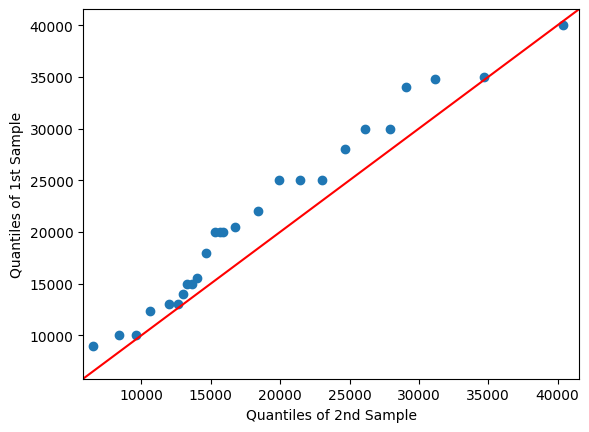

In [27]:
# qq-plot для оригинальных и синтетических данных
sm.qqplot_2samples(five['ЗП'].values, sinted_five['ЗП'].values, line='45').savefig('dessfeferg.png', dpi=300)

In [28]:
new_data.rename(columns = {'ЗП':'yj13.2',
                     'Образование':'yj72.18a',
                     'Рабочая неделя':'yj6.2',
                     'Премия':'yj10.2',
                     'Отпуск':'yj21b',
                     'Удовлетворённость':'yj1.1.1'
                       },
                inplace = True)

In [29]:
new_data.to_csv('data/Balanced_dataset.csv', index=False)